In [17]:
%load_ext autoreload
%autoreload 2

In [18]:
import torch
import torch.nn.functional as F
import llminference as L
import llminference.sparse_attention as sa
import datasets
import matplotlib.pyplot as plt
import unittest.mock as um
from functools import partial
import pandas as pd

## Average left-over tokens

Instead of zeroing all non-top-k attention scores, let's try assigning the left-over softmax weight to an *average* of the leftover tokens as an approximation. This only makes sense if we keep track of the value average (as transferring non-top-k value from memory defeats the purpose of the algorithm)

## Test implementation

In [19]:
from sweep_sparse_v_avg import sparse_softmax_with_avgs
k = 2
x = torch.tensor([0.3, 0.1, 0.5, 0.2, 0.4])
s = F.softmax(x, dim=-1)
avg = (s[0] + s[1] + s[3]) / 3
expected = torch.tensor([avg, avg, s[2], avg, s[4]])
out = sparse_softmax_with_avgs(x, k)
print(out)
print(expected)

tensor([0.1798, 0.1798, 0.2419, 0.1798, 0.2188])
tensor([0.1798, 0.1798, 0.2419, 0.1798, 0.2188])


## Results

In [20]:
df = pd.read_json("./results/triviaqa_sparse_v_with_avg.jsonl", lines=True)

In [21]:
df

,model,open_book_acc,k,use_avg,_duration
0,pythia-70m,0.011236,8,True,51.328176
1,pythia-70m,0.006742,8,False,62.936743
2,pythia-70m,0.015730,16,True,62.073191
3,pythia-70m,0.013483,16,False,51.421554
4,pythia-70m,0.015730,32,True,63.914898
5,pythia-70m,0.017978,32,False,57.737274
6,pythia-70m,0.020225,128,True,55.921932
7,pythia-70m,0.020225,128,False,57.918354
8,pythia-160m,0.022472,8,True,149.026552
9,pythia-160m,0.053933,8,False,144.067255


In [22]:
# Filter out the smaller models
models_to_plot = ["pythia-410m", "pythia-1b", "pythia-2.8b"]
df = df.loc[df["model"].isin(models_to_plot)]

In [23]:
df_b = pd.read_json("./results/triviaqa_sparse_v_baseline.jsonl", lines=True)
df_b = df_b.loc[df_b["model"].isin(models_to_plot)]

In [24]:
model_grouped = df.groupby("model", sort=False)

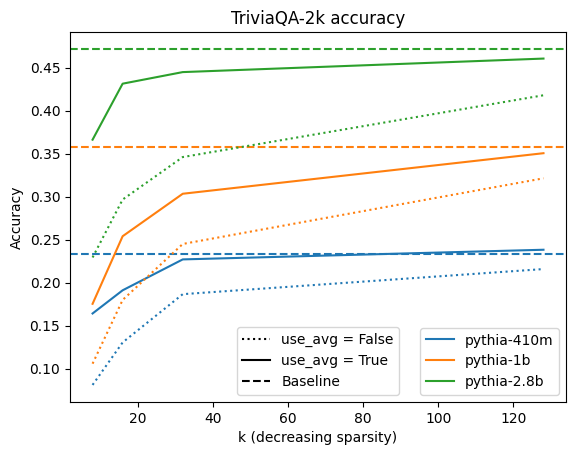

In [25]:
fig, axes = plt.subplots()
linestyles = [":", "-"]
models = []
for i, (model, group) in enumerate(model_grouped):
    models.append(model)
    col = f"C{i}"
    
    # Plot dense baseline
    y = df_b.loc[(df_b["model"] == model) & (df_b['open_book'] == True), "acc"].values[0]
    plt.axhline(y = y, color = col, linestyle="--")
    
    avg_grouped = group.groupby("use_avg")
    for (use_avg, group), linestyle in zip(avg_grouped, linestyles):
        axes.plot(group["k"], group["open_book_acc"], label=f"{model}, use_avg={use_avg}", color=col, linestyle=linestyle)
lines = axes.get_lines()[2::3]

# Dummy lines
dummy_lines = []
for linestyle in linestyles:
    # axes.plot([], [], c="black", linestyle=linestyle)
    dummy_lines.append(axes.plot([],[], c="black", linestyle=linestyle)[0])
# Add baseline line
dummy_lines.append(axes.plot([],[], c="black", linestyle="--")[0])

legend1 = axes.legend(lines, models, loc="lower right")
legend2 = axes.legend(dummy_lines, ["use_avg = False", "use_avg = True", "Baseline"], loc="lower center")
axes.add_artist(legend1)
plt.xlabel("k (decreasing sparsity)")
plt.ylabel("Accuracy")
plt.title("TriviaQA-2k accuracy")
plt.show()